<a href="https://colab.research.google.com/github/soobook/PyTorch-DL/blob/main/code/PT18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 18회차: DC-GAN을 활용한 손글씨 모방하기 (4) - 모델 최적화

In [2]:
# ================================================================
# DC-GAN (PyTorch / MNIST) - 업그레이드 적용 포함 버전
# ================================================================

# (1) 필수 라이브러리 임포트 및 설정
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# (2) 하이퍼파라미터 및 디바이스 설정
lr = 0.0002
batch_size = 128
image_size = 64
nz = 100
num_epochs = 20
beta1 = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# (3) 데이터셋 준비 (MNIST 로드 및 전처리)
# [업그레이드 적용] 데이터 증강 추가
transform = transforms.Compose([
    transforms.RandomRotation(3),  # 랜덤 회전
    transforms.RandomAffine( # 랜덤 이동
      0,                   # 회전 각도 범위 (degrees)
      # 이미지 너비의 최대 5%만큼 좌우로 이동
      # 이미지 높이의 최대 5%만큼 상하로 이동
      translate=(0.05, 0.05) # 이동 비율 (x축, y축)
    ),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [3]:
# (4) Discriminator 클래스 정의 (Dropout 포함)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)

# (5) Generator 클래스 정의 (InstanceNorm으로 변경)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.InstanceNorm2d(512),  # [업그레이드 적용] InstanceNorm
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(256),  # [업그레이드 적용]
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),  # 하위는 BatchNorm으로
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# (6) 모델 객체 생성 및 초기화
netG = Generator().to(device)
netD = Discriminator().to(device)

print("=== Generator (netG) 구조 ===")
print(netG)
print("\n=== Discriminator (netD) 구조 ===")
print(netD)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

##------------------------ 가중치 초기화 -----------------------
# 각 계층에 대해 초기화 함수 정의
def weights_init(m):
    # 현재 계층의 클래스 이름을 소문자로 가져옴 (예: 'conv2d', 'batchnorm2d')
    classname = m.__class__.__name__.lower()
    # Conv 계열 레이어일 경우 (Conv2d, ConvTranspose2d 등)
    if "conv" in classname:
        # weight가 존재하면 평균 0, 표준편차 0.02인 정규분포로 초기화
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)

    # BatchNorm 또는 InstanceNorm 계열 레이어일 경우
    elif "batchnorm" in classname or "instancenorm" in classname:
        # weight가 존재하면 평균 1, 표준편차 0.02로 초기화
        if hasattr(m, 'weight') and m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        # bias가 존재하면 0으로 초기화
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

# Generator(netG)에 위에서 정의한 초기화 함수를 적용
netG.apply(weights_init)
# Discriminator(netD)에 초기화 함수 적용
netD.apply(weights_init)

=== Generator (netG) 구조 ===
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [4]:
b_size = batch_size
label_real = torch.full((b_size,), 0.98, dtype=torch.float, device=device)
label_real

tensor([0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800,
        0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800,
        0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800,
        0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800,
        0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800,
        0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800,
        0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800,
        0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800,
        0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800,
        0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800,
        0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800,
        0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800, 0.9800,
        0.9800, 0.9800, 0.9800, 0.9800, 

In [ ]:
save_dir = './gen_images'
os.makedirs(save_dir, exist_ok=True)

G_losses = []
D_losses = []

# (7) 학습 루프
num_epochs = 20
for epoch in range(1, num_epochs+1):
    G_epoch_loss = 0.0
    D_epoch_loss = 0.0
    num_batches = 0

    for i, (real, _) in enumerate(dataloader):
        netD.zero_grad()
        real = real.to(device)
        b_size = real.size(0)

        # [업그레이드 적용] Label Smoothing: 진짜 레이블을 0.98로 설정
        label_real = torch.full((b_size,), 0.98, dtype=torch.float, device=device)
        output_real = netD(real)
        errD_real = criterion(output_real, label_real)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise).detach()
        label_fake = torch.full((b_size,), 0.0, dtype=torch.float, device=device)
        output_fake = netD(fake)
        errD_fake = criterion(output_fake, label_fake)
        errD_fake.backward()

        optimizerD.step()

        netG.zero_grad()
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label_gen = torch.full((b_size,), 1.0, dtype=torch.float, device=device)
        output = netD(fake)
        errG = criterion(output, label_gen)
        errG.backward()
        optimizerG.step()

        G_epoch_loss += errG.item()
        D_epoch_loss += (errD_real + errD_fake).item()
        num_batches += 1

        if i % 100 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD_real+errD_fake:.4f} Loss_G: {errG:.4f}")

    G_losses.append(G_epoch_loss / num_batches)
    D_losses.append(D_epoch_loss / num_batches)

    if (epoch % 5 == 0):
        with torch.no_grad():
            fake = netG(fixed_noise[:16]).detach().cpu()
            vutils.save_image(
                fake,
                f"{save_dir}/epoch_{epoch:03d}.png",
                normalize=True,
                nrow=4
            )

=== Generator (netG) 구조 ===
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1

### 이상적인 손실값 추이

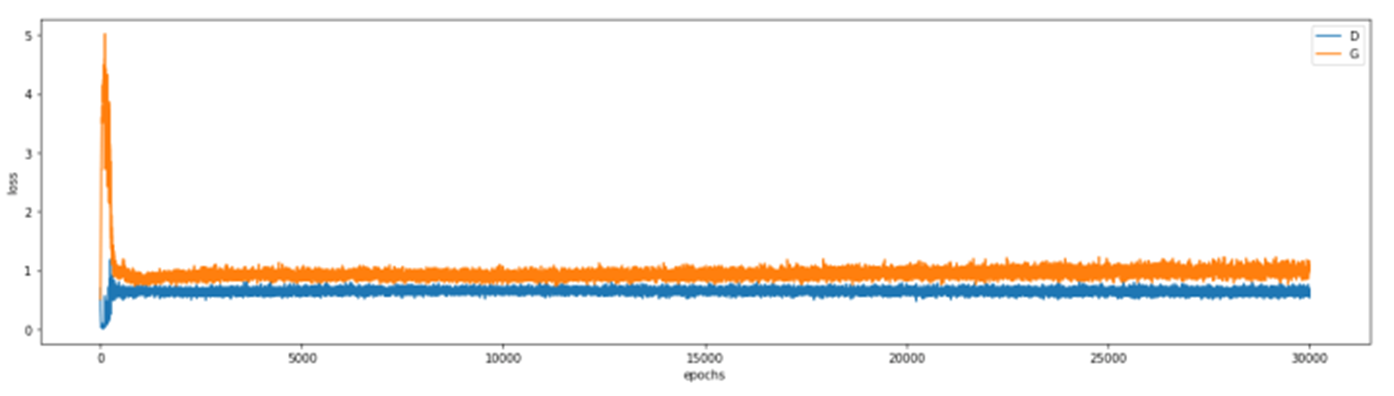

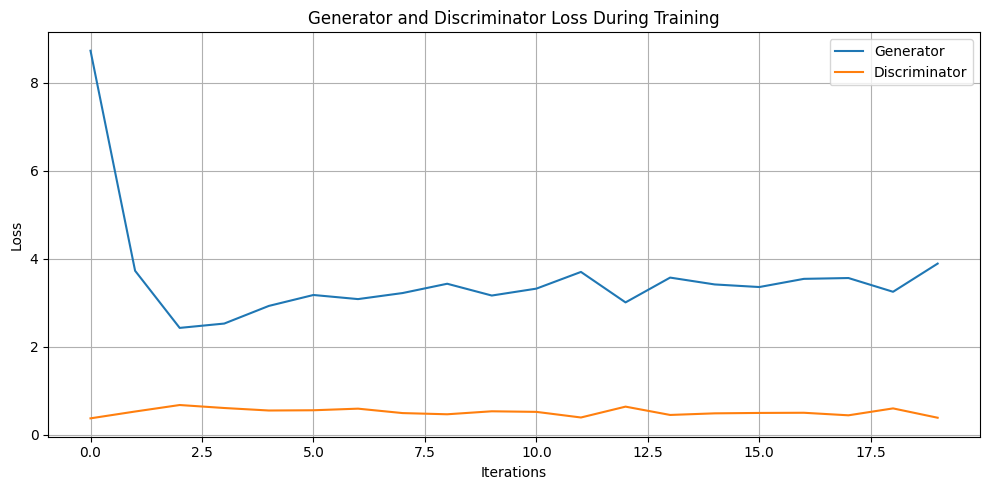

In [ ]:
# (11) 학습 후 손실 시각화
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()

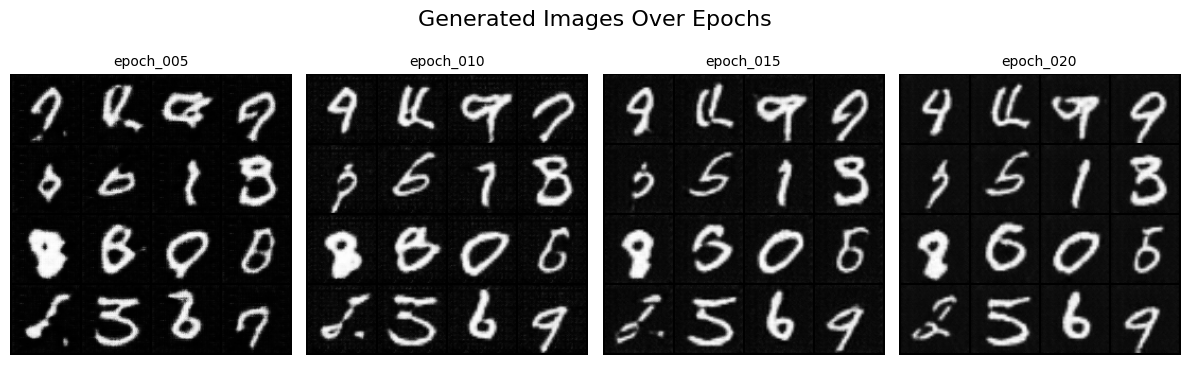

In [ ]:
# (12) 에폭별 생성 이미지 시각화
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os

# 저장 폴더 지정
image_dir = './gen_images'

# PNG 이미지 파일 경로 가져오기
image_paths = sorted(glob.glob(os.path.join(image_dir, 'epoch_*.png')))

# 이미지 개수와 subplot 행렬 구성
num_images = len(image_paths)
cols = 4
rows = (num_images + cols - 1) // cols

# subplot 설정
plt.figure(figsize=(cols * 3, rows * 4))
for idx, path in enumerate(image_paths):
    img = mpimg.imread(path)
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(os.path.basename(path).replace('.png', ''), fontsize=10)
    plt.axis('off')

# 레이아웃 조정 및 제목 위치 이동
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # 상단 여백 확보
plt.suptitle("Generated Images Over Epochs", fontsize=16)
plt.show()

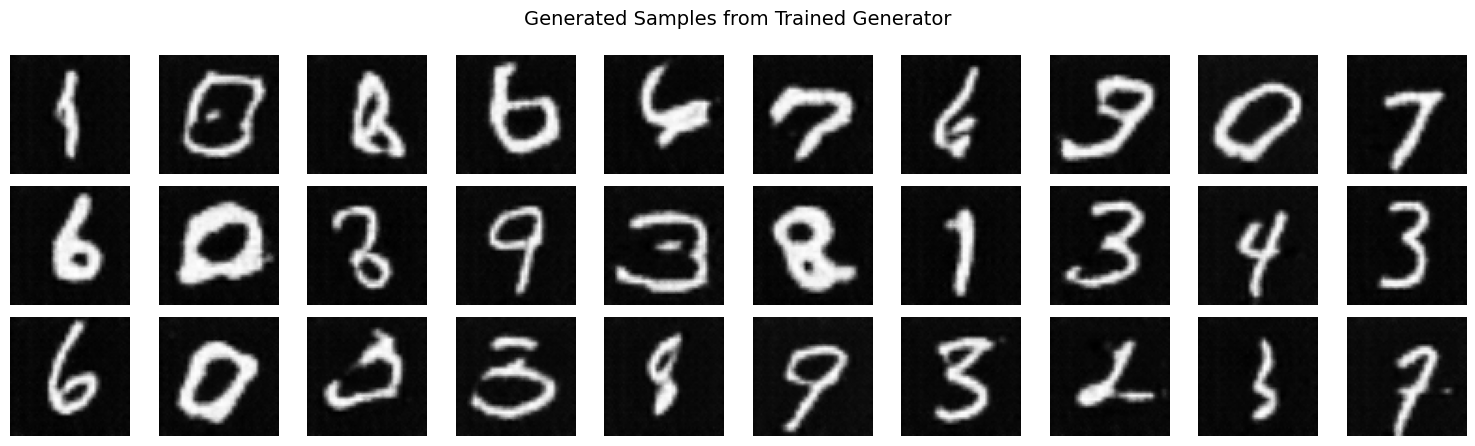

In [ ]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# (12) 훈련된 Generator로부터 30개 샘플 생성 및 시각화

# 생성할 샘플 수
num_samples = 30
rows = 3
cols = 10

# latent vector z 생성 (랜덤 잡음)
noise = torch.randn(num_samples, nz, 1, 1, device=device)

# Generator로부터 가짜 이미지 생성
with torch.no_grad():
    fake_images = netG(noise).detach().cpu()

# 정규화된 이미지 [-1, 1] → [0, 1]로 다시 변환
fake_images = (fake_images + 1) / 2

# 시각화
fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
for idx, ax in enumerate(axes.flat):
    ax.imshow(fake_images[idx][0], cmap='gray')  # 흑백 이미지이므로 [0] 채널만
    ax.axis('off')

plt.suptitle("Generated Samples from Trained Generator", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # 제목 여백
plt.show()


## 종료